In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import chi2_contingency
import os
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [3]:
df = pd.read_csv('C:/Users/Arosha IIT/OneDrive - Robert Gordon University/Desktop/AIDS NOTES/CM2604/CM2604/data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv')
print(f"Dataset shape: {df.shape}")
print(f"Dataset loaded successfully!")

Dataset shape: (7043, 21)
Dataset loaded successfully!


In [4]:
def data_quality_report(dataframe):
    report = pd.DataFrame({
        'dtype': dataframe.dtypes,
        'missing_count': dataframe.isnull().sum(),
        'missing_percentage': (dataframe.isnull().sum() / len(dataframe)) * 100,
        'unique_count': dataframe.nunique(),
        'unique_percentage': (dataframe.nunique() / len(dataframe)) * 100
    })

    numerical_cols = dataframe.select_dtypes(include=[np.number]).columns
    categorical_cols = dataframe.select_dtypes(include=['object']).columns

    numerical_stats = dataframe[numerical_cols].describe().T
    categorical_stats = dataframe[categorical_cols].describe().T

    return report, numerical_stats, categorical_stats

quality_report, num_stats, cat_stats = data_quality_report(df)
print("DATA QUALITY REPORT:")
print(quality_report)

DATA QUALITY REPORT:
                    dtype  missing_count  missing_percentage  unique_count  \
customerID         object              0                 0.0          7043   
gender             object              0                 0.0             2   
SeniorCitizen       int64              0                 0.0             2   
Partner            object              0                 0.0             2   
Dependents         object              0                 0.0             2   
tenure              int64              0                 0.0            73   
PhoneService       object              0                 0.0             2   
MultipleLines      object              0                 0.0             3   
InternetService    object              0                 0.0             3   
OnlineSecurity     object              0                 0.0             3   
OnlineBackup       object              0                 0.0             3   
DeviceProtection   object              0   

In [5]:
df_clean = df.copy()

print("TotalCharges unique values before conversion:")
print(df_clean['TotalCharges'].unique()[:10])

df_clean['TotalCharges'] = pd.to_numeric(df_clean['TotalCharges'], errors='coerce')

print(f"Missing values after conversion: {df_clean['TotalCharges'].isnull().sum()}")

median_charges = df_clean['TotalCharges'].median()
df_clean['TotalCharges'] = df_clean['TotalCharges'].fillna(median_charges)

df_clean['Churn_numeric'] = df_clean['Churn'].map({'No': 0, 'Yes': 1})
df_clean['SeniorCitizen'] = df_clean['SeniorCitizen'].astype('object')

print("Data types after cleaning:")
print(df_clean.dtypes)

TotalCharges unique values before conversion:
['29.85' '1889.5' '108.15' '1840.75' '151.65' '820.5' '1949.4' '301.9'
 '3046.05' '3487.95']
Missing values after conversion: 11
Data types after cleaning:
customerID           object
gender               object
SeniorCitizen        object
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
Churn_numeric         int64
dtype: object


In [6]:
def statistical_analysis(dataframe, target='Churn_numeric'):
    numerical_features = dataframe.select_dtypes(include=[np.number]).columns
    numerical_features = numerical_features.drop(target) if target in numerical_features else numerical_features

    stats_results = {}

    for feature in numerical_features:
        churn_yes = dataframe[dataframe[target] == 1][feature]
        churn_no = dataframe[dataframe[target] == 0][feature]

        t_stat, p_value = stats.ttest_ind(churn_yes, churn_no, nan_policy='omit')

        stats_results[feature] = {
            't_statistic': t_stat,
            'p_value': p_value,
            'mean_churn_yes': churn_yes.mean(),
            'mean_churn_no': churn_no.mean(),
            'effect_size': (churn_yes.mean() - churn_no.mean()) / np.sqrt((churn_yes.std()**2 + churn_no.std()**2)/2)
        }

    return pd.DataFrame(stats_results).T

statistical_results = statistical_analysis(df_clean)
print("STATISTICAL SIGNIFICANCE TEST RESULTS:")
print(statistical_results)

STATISTICAL SIGNIFICANCE TEST RESULTS:
                t_statistic        p_value  mean_churn_yes  mean_churn_no  \
tenure           -31.579551  7.999058e-205       17.979133      37.569965   
MonthlyCharges    16.536738   2.706646e-60       74.441332      61.265124   
TotalCharges     -17.042295   7.508609e-64     1531.796094    2552.882494   

                effect_size  
tenure            -0.892829  
MonthlyCharges     0.469507  
TotalCharges      -0.481535  


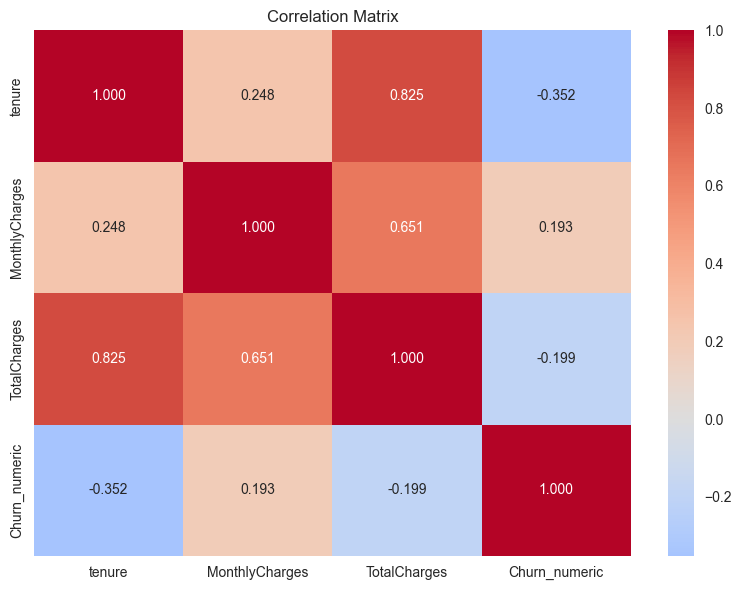

CRAMER'S V ASSOCIATION WITH CHURN:
                  cramers_v        p_value
Contract           0.410116  5.863038e-258
InternetService    0.322455  9.571788e-160
PaymentMethod      0.303359  3.682355e-140
PaperlessBilling   0.191498   4.073355e-58
Dependents         0.163870   4.924922e-43
Partner            0.150126   2.139911e-36
PhoneService       0.011398   3.387825e-01
gender             0.008291   4.865787e-01


In [7]:
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn_numeric']
correlation_matrix = df_clean[numerical_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.3f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

categorical_features = ['gender', 'Partner', 'Dependents', 'PhoneService', 'InternetService',
                       'Contract', 'PaperlessBilling', 'PaymentMethod']

cramers_v_results = {}

for feature in categorical_features:
    contingency_table = pd.crosstab(df_clean[feature], df_clean['Churn'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
    cramers_v_results[feature] = {'cramers_v': cramers_v, 'p_value': p_value}

cramers_v_df = pd.DataFrame(cramers_v_results).T
print("CRAMER'S V ASSOCIATION WITH CHURN:")
print(cramers_v_df.sort_values('cramers_v', ascending=False))

In [8]:
def detect_outliers_iqr(dataframe, features):
    outlier_report = {}

    for feature in features:
        Q1 = dataframe[feature].quantile(0.25)
        Q3 = dataframe[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = dataframe[(dataframe[feature] < lower_bound) | (dataframe[feature] > upper_bound)]
        outlier_percentage = (len(outliers) / len(dataframe)) * 100

        outlier_report[feature] = {
            'lower_bound': lower_bound,
            'upper_bound': upper_bound,
            'outlier_count': len(outliers),
            'outlier_percentage': outlier_percentage
        }

    return pd.DataFrame(outlier_report).T

numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
outlier_report_iqr = detect_outliers_iqr(df_clean, numerical_cols)
print("OUTLIER DETECTION (IQR METHOD):")
print(outlier_report_iqr)

def detect_outliers_zscore(dataframe, features, threshold=3):
    outlier_report = {}

    for feature in features:
        z_scores = np.abs(stats.zscore(dataframe[feature].dropna()))
        outliers = dataframe[z_scores > threshold]
        outlier_percentage = (len(outliers) / len(dataframe)) * 100

        outlier_report[feature] = {
            'outlier_count': len(outliers),
            'outlier_percentage': outlier_percentage,
            'max_z_score': z_scores.max()
        }

    return pd.DataFrame(outlier_report).T

outlier_report_zscore = detect_outliers_zscore(df_clean, numerical_cols)
print("OUTLIER DETECTION (Z-SCORE METHOD):")
print(outlier_report_zscore)

OUTLIER DETECTION (IQR METHOD):
                lower_bound  upper_bound  outlier_count  outlier_percentage
tenure             -60.0000     124.0000            0.0                 0.0
MonthlyCharges     -46.0250     171.3750            0.0                 0.0
TotalCharges     -4674.3375    8863.1625            0.0                 0.0
OUTLIER DETECTION (Z-SCORE METHOD):
                outlier_count  outlier_percentage  max_z_score
tenure                    0.0                 0.0     1.613701
MonthlyCharges            0.0                 0.0     1.794352
TotalCharges              0.0                 0.0     2.826743


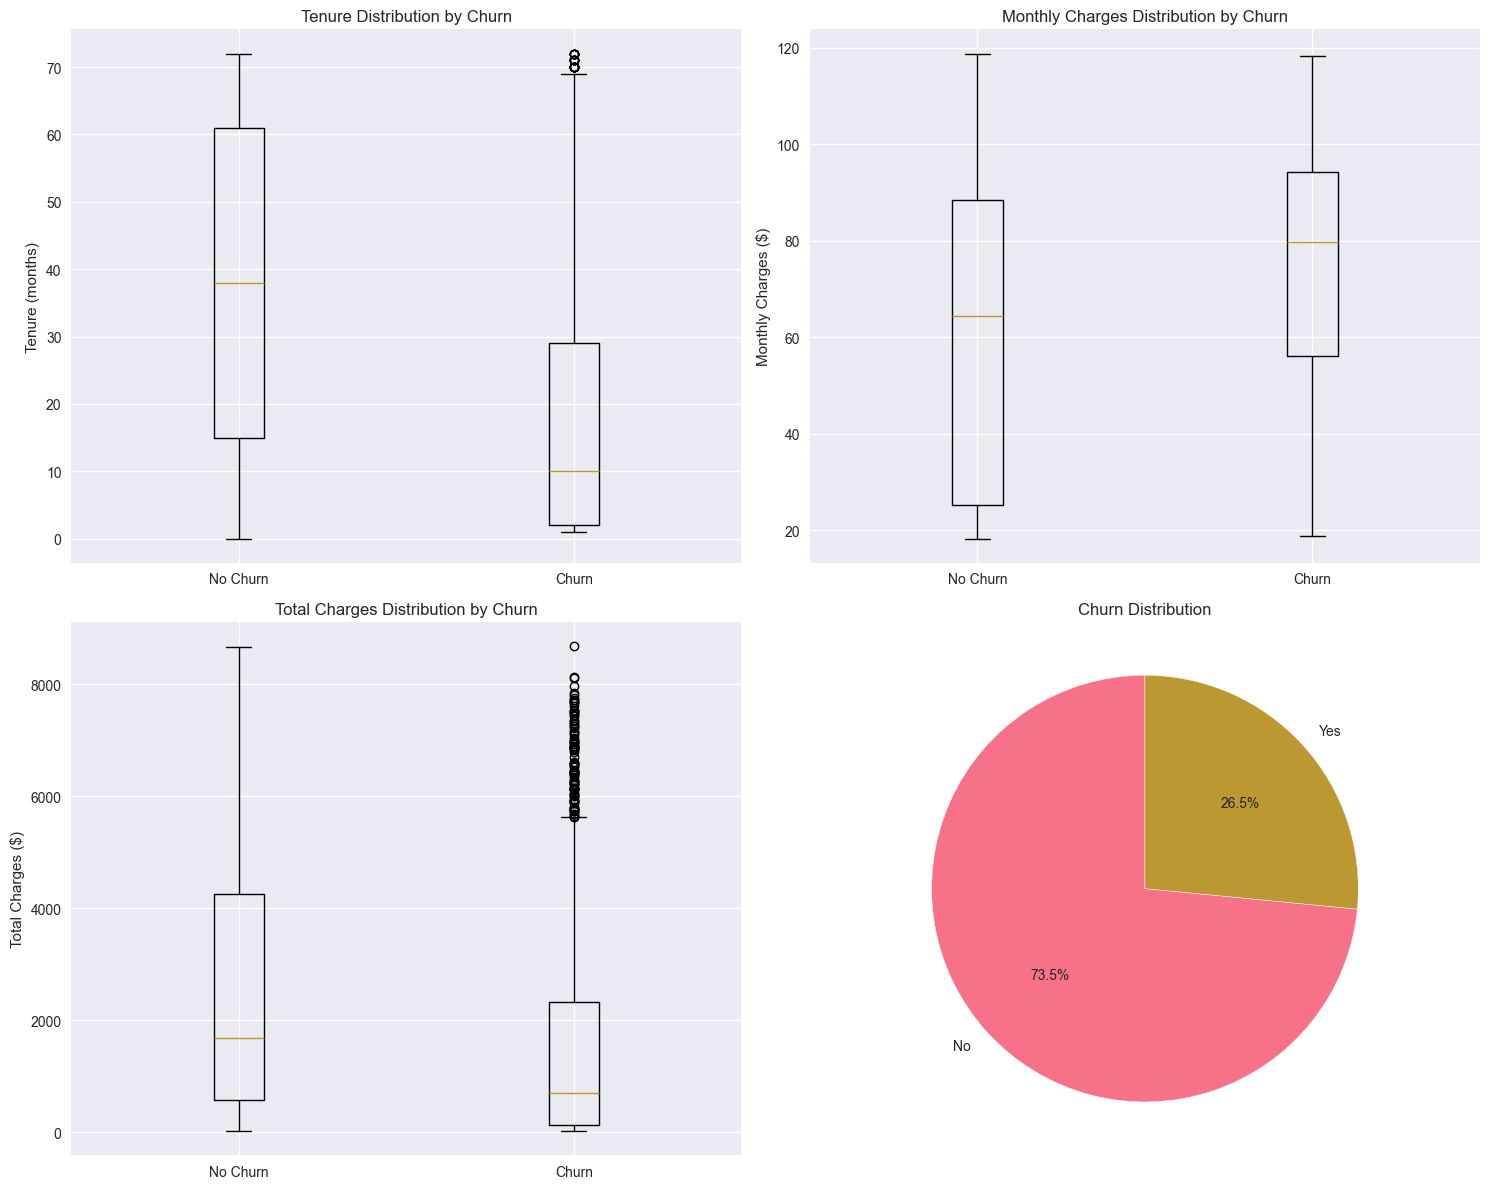

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0,0].boxplot([df_clean[df_clean['Churn'] == 'No']['tenure'],
                   df_clean[df_clean['Churn'] == 'Yes']['tenure']])
axes[0,0].set_title('Tenure Distribution by Churn')
axes[0,0].set_xticklabels(['No Churn', 'Churn'])
axes[0,0].set_ylabel('Tenure (months)')

axes[0,1].boxplot([df_clean[df_clean['Churn'] == 'No']['MonthlyCharges'],
                   df_clean[df_clean['Churn'] == 'Yes']['MonthlyCharges']])
axes[0,1].set_title('Monthly Charges Distribution by Churn')
axes[0,1].set_xticklabels(['No Churn', 'Churn'])
axes[0,1].set_ylabel('Monthly Charges ($)')

axes[1,0].boxplot([df_clean[df_clean['Churn'] == 'No']['TotalCharges'],
                   df_clean[df_clean['Churn'] == 'Yes']['TotalCharges']])
axes[1,0].set_title('Total Charges Distribution by Churn')
axes[1,0].set_xticklabels(['No Churn', 'Churn'])
axes[1,0].set_ylabel('Total Charges ($)')

churn_counts = df_clean['Churn'].value_counts()
axes[1,1].pie(churn_counts.values, labels=churn_counts.index, autopct='%1.1f%%', startangle=90)
axes[1,1].set_title('Churn Distribution')

plt.tight_layout()
plt.savefig('C:/Users/Arosha IIT/OneDrive - Robert Gordon University/Desktop/AIDS NOTES/CM2604/CM2604/reports/visualizations/distribution_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

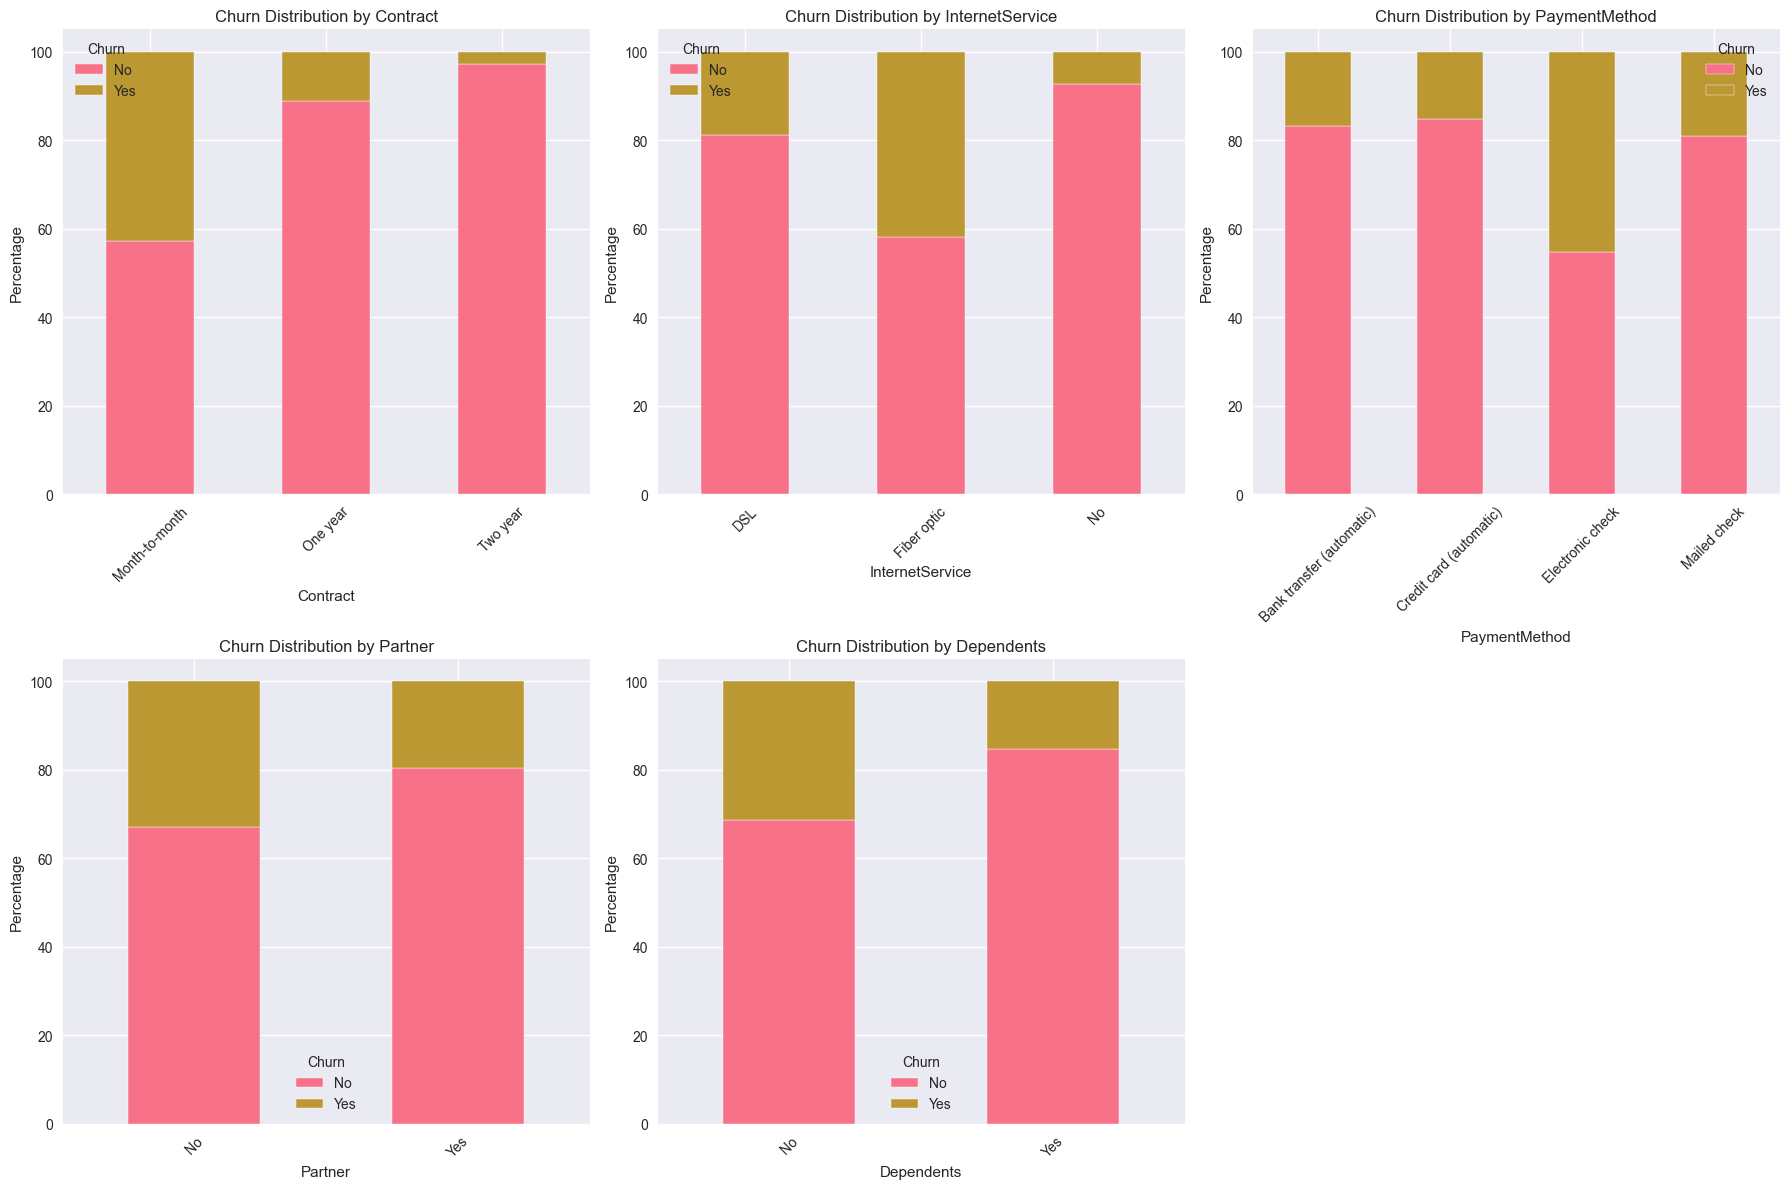

In [10]:
categorical_features = ['Contract', 'InternetService', 'PaymentMethod', 'Partner', 'Dependents']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, feature in enumerate(categorical_features[:6]):
    cross_tab = pd.crosstab(df_clean[feature], df_clean['Churn'], normalize='index') * 100
    cross_tab.plot(kind='bar', ax=axes[i], stacked=True)
    axes[i].set_title(f'Churn Distribution by {feature}')
    axes[i].set_ylabel('Percentage')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].legend(title='Churn')

if len(categorical_features) < 6:
    for i in range(len(categorical_features), 6):
        fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig('C:/Users/Arosha IIT/OneDrive - Robert Gordon University/Desktop/AIDS NOTES/CM2604/CM2604/reports/visualizations/categorical_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
def generate_automated_insights(dataframe):
    insights = []

    churn_rate = (dataframe['Churn_numeric'].mean() * 100)
    insights.append(f"Overall churn rate: {churn_rate:.1f}%")

    numerical_corr = dataframe[['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn_numeric']].corr()['Churn_numeric'].sort_values(ascending=False)
    strongest_corr_feature = numerical_corr.index[1]
    strongest_corr_value = numerical_corr.iloc[1]
    insights.append(f"Strongest numerical correlation with churn: {strongest_corr_feature} (r = {strongest_corr_value:.3f})")

    high_churn_contract = dataframe.groupby('Contract')['Churn_numeric'].mean().sort_values(ascending=False).index[0]
    high_churn_rate = dataframe.groupby('Contract')['Churn_numeric'].mean().sort_values(ascending=False).iloc[0] * 100
    insights.append(f"Highest churn rate by contract: {high_churn_contract} ({high_churn_rate:.1f}%)")

    high_churn_internet = dataframe.groupby('InternetService')['Churn_numeric'].mean().sort_values(ascending=False).index[0]
    high_churn_rate_internet = dataframe.groupby('InternetService')['Churn_numeric'].mean().sort_values(ascending=False).iloc[0] * 100
    insights.append(f"Highest churn rate by internet service: {high_churn_internet} ({high_churn_rate_internet:.1f}%)")

    tenure_churn_corr = dataframe['tenure'].corr(dataframe['Churn_numeric'])
    insights.append(f"Tenure-Churn correlation: {tenure_churn_corr:.3f} (longer tenure = lower churn)")

    avg_tenure_churn = dataframe[dataframe['Churn_numeric'] == 1]['tenure'].mean()
    avg_tenure_no_churn = dataframe[dataframe['Churn_numeric'] == 0]['tenure'].mean()
    insights.append(f"Average tenure - Churn: {avg_tenure_churn:.1f} months vs No Churn: {avg_tenure_no_churn:.1f} months")

    avg_monthly_churn = dataframe[dataframe['Churn_numeric'] == 1]['MonthlyCharges'].mean()
    avg_monthly_no_churn = dataframe[dataframe['Churn_numeric'] == 0]['MonthlyCharges'].mean()
    insights.append(f"Average monthly charges - Churn: ${avg_monthly_churn:.2f} vs No Churn: ${avg_monthly_no_churn:.2f}")

    return insights

automated_insights = generate_automated_insights(df_clean)
print("AUTOMATED INSIGHTS:")
for i, insight in enumerate(automated_insights, 1):
    print(f"{i}. {insight}")

AUTOMATED INSIGHTS:
1. Overall churn rate: 26.5%
2. Strongest numerical correlation with churn: MonthlyCharges (r = 0.193)
3. Highest churn rate by contract: Month-to-month (42.7%)
4. Highest churn rate by internet service: Fiber optic (41.9%)
5. Tenure-Churn correlation: -0.352 (longer tenure = lower churn)
6. Average tenure - Churn: 18.0 months vs No Churn: 37.6 months
7. Average monthly charges - Churn: $74.44 vs No Churn: $61.27


In [12]:
df_clean.to_csv('C:/Users/Arosha IIT/OneDrive - Robert Gordon University/Desktop/AIDS NOTES/CM2604/CM2604/data/processed/telco_cleaned.csv', index=False)
print("Cleaned dataset saved successfully!")

Cleaned dataset saved successfully!


In [13]:
def generate_summary_report(dataframe):
    summary = {
        'dataset_shape': dataframe.shape,
        'churn_rate': (dataframe['Churn_numeric'].mean() * 100),
        'numerical_features': list(dataframe.select_dtypes(include=[np.number]).columns),
        'categorical_features': list(dataframe.select_dtypes(include=['object']).columns),
        'missing_values_total': dataframe.isnull().sum().sum(),
        'data_quality_score': (1 - (dataframe.isnull().sum().sum() / (dataframe.shape[0] * dataframe.shape[1]))) * 100,
        'average_tenure': dataframe['tenure'].mean(),
        'average_monthly_charges': dataframe['MonthlyCharges'].mean(),
        'most_common_contract': dataframe['Contract'].mode()[0],
        'most_common_internet_service': dataframe['InternetService'].mode()[0]
    }
    return summary

summary_report = generate_summary_report(df_clean)
print("COMPREHENSIVE SUMMARY REPORT:")
for key, value in summary_report.items():
    print(f"{key}: {value}")

COMPREHENSIVE SUMMARY REPORT:
dataset_shape: (7043, 22)
churn_rate: 26.536987079369588
numerical_features: ['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn_numeric']
categorical_features: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']
missing_values_total: 0
data_quality_score: 100.0
average_tenure: 32.37114865824223
average_monthly_charges: 64.76169246059918
most_common_contract: Month-to-month
most_common_internet_service: Fiber optic
